# Task & Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1cQd70q70pNlchzBSD0zngjK1eew5TERO
!unzip /content/image_processing_task1.zip -d /content/image_processing_data

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1cQd70q70pNlchzBSD0zngjK1eew5TERO
To: /content/image_processing_task1.zip
100% 378k/378k [00:00<00:00, 5.90MB/s]
Archive:  /content/image_processing_task1.zip
  inflating: /content/image_processing_data/Decsription.docx  
  inflating: /content/image_processing_data/GRAY.JPG  
  inflating: /content/image_processing_data/RGB_half.JPG  
  inflating: /content/image_processing_data/RGB_quater.JPG  


In [ ]:
!pip install python-docx 
from docx import Document

In [ ]:
filename='/content/image_processing_data/Decsription.docx'
doc = Document(filename)

list(map(print, [x.text for x in doc.paragraphs]))

Task description:
Using 3 images : GRAY.JPG (gray scale image with high resolution), RGB_half.JPG (rotated RGB image with lower resolution), RGB_quater.JPG(rotated RGB image with the lower resolution than other RGB) reconstruct RGB image of same resolution which has GRAY.JPG
Link to the data:

What you need to do:
1. Reconstruct RGB from 3 images (2 results – from pair GRAY.JPG and RG_half.JPG and – from pair GRAY.JPG and RGB_quater.JPG)
2. Compare quality of reconstruction visually
Comment:
You could use any algorithms for pan sharpening and for aligning images coordinate systems.
 
But for the start point you could see on materials (openCV samples and some links about image color spaces)


[None, None, None, None, None, None, None, None, None, None, None]

# Dependencies

In [ ]:
!pip install numexpr

In [2]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.6 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.6 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Images

In [4]:
image_to_rotate_half = cv2.imread('/content/image_processing_data/RGB_half.JPG')[:,:,::-1]
image_to_rotate_quarter = cv2.imread('/content/image_processing_data/RGB_quater.JPG')[:,:,::-1]
gray_target_image = cv2.imread('/content/image_processing_data/GRAY.JPG')[:,:,::-1] 

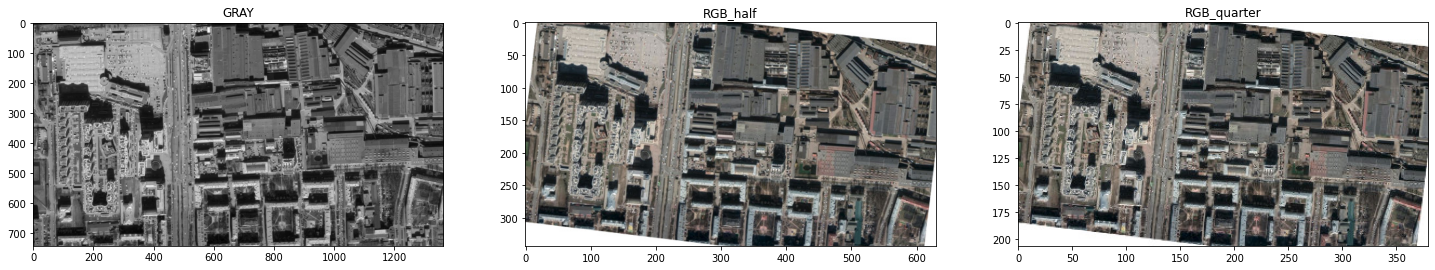

In [5]:
fig = plt.figure(figsize=(25, 8))
plt.subplot(131), plt.imshow(gray_target_image,'gray'), plt.title('GRAY')
plt.subplot(132), plt.imshow(image_to_rotate_half), plt.title('RGB_half')
plt.subplot(133), plt.imshow(image_to_rotate_quarter), plt.title('RGB_quarter')
plt.show()

# Alignment

## Run SURF detector

In [6]:
# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create(400)

# find the keypoints and descriptors with SIFT
kp_target, des_target= surf.detectAndCompute(gray_target_image, None)
kp_half, des_half = surf.detectAndCompute(image_to_rotate_half, None)
kp_quarter, des_quarter = surf.detectAndCompute(image_to_rotate_quarter, None)

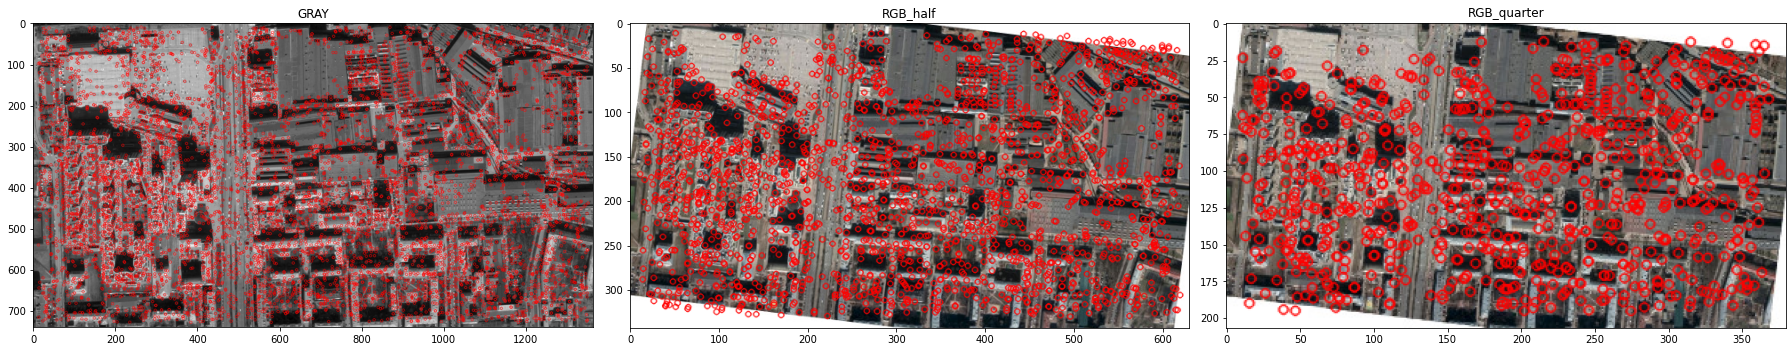

In [7]:
target_with_keys = cv2.drawKeypoints(gray_target_image, kp_target, None,(255,0,0), 2)
half_with_keys = cv2.drawKeypoints(image_to_rotate_half, kp_half, None,(255,0,0), 2)
quarter_with_keys = cv2.drawKeypoints(image_to_rotate_quarter, kp_quarter, None,(255,0,0), 2)

fig = plt.figure(figsize=(25, 8))
plt.subplot(131), plt.imshow(target_with_keys,'gray'), plt.title('GRAY')
plt.subplot(132), plt.imshow(half_with_keys), plt.title('RGB_half')
plt.subplot(133), plt.imshow(quarter_with_keys), plt.title('RGB_quarter')
plt.tight_layout()
plt.show()

## Run Matcher

In [8]:
def flann_function(des_target, des_support):
    # intitiate FlannBasedMatcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # match deses
    matches = flann.knnMatch(des_target, des_support, k=2)
    # store all the good matches as per Lowe's ratio test.
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    return good_matches

In [9]:
matches_half = flann_function(des_target, des_half)
matches_quarter = flann_function(des_target, des_quarter)

## Finding transformation matrix

In [10]:
src_pts_half = np.float32([kp_target[m.queryIdx].pt for m in matches_half]).reshape(-1, 1, 2)
dst_pts_half = np.float32([kp_half[m.trainIdx].pt for m in matches_half]).reshape(-1, 1, 2)

src_pts_quarter = np.float32([kp_target[m.queryIdx].pt for m in matches_quarter]).reshape(-1, 1, 2)
dst_pts_half_quarter = np.float32([kp_quarter[m.trainIdx].pt for m in matches_quarter]).reshape(-1, 1, 2)

transformation_half, mask_half = cv2.findHomography(dst_pts_half, src_pts_half, cv2.RANSAC, 5.0)
matchesMask_half = mask_half.ravel().tolist()

transformation_quarter, mask_quarter = cv2.findHomography(dst_pts_half_quarter, src_pts_quarter, cv2.RANSAC, 5.0)
matchesMask_quarter = mask_quarter.ravel().tolist()

## Draw Matches

In [11]:
draw_params_h = dict(matchColor = (0, 255, 0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask_half, # draw only inliers
                   flags = 2)

draw_params_q = dict(matchColor = (0, 255, 0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask_quarter, # draw only inliers
                   flags = 2)

img_half = cv2.drawMatches(
    gray_target_image, kp_target,
    image_to_rotate_half, kp_half, 
    matches_half, None, **draw_params_h
)

img_quarter = cv2.drawMatches(
    gray_target_image, kp_target,
    image_to_rotate_quarter, kp_quarter, 
    matches_quarter, None, **draw_params_q
)

fig = plt.figure(figsize=(17, 13))
plt.subplot(211)
plt.imshow(img_half)
plt.title("RGB_half + Grey matches")
plt.subplot(212)
plt.imshow(img_quarter)
plt.title("RGB_quarter + Grey matches")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Warping perspective of the RGB images

In [47]:
def draw_image(image_1, image_2, image_3, 
               title_1, title_2, title_3):
    fig = plt.figure(figsize=(25, 10))
    plt.subplot(131)
    plt.imshow(image_1), plt.title(title_1)
    plt.subplot(132)
    plt.imshow(image_2), plt.title(title_2)
    plt.subplot(133)
    plt.imshow(image_3), plt.title(title_3)
    plt.tight_layout()
    plt.show()

In [12]:
height, width = gray_target_image.shape[:2]
rotated_half = cv2.warpPerspective(image_to_rotate_half, transformation_half, (width, height))
rotated_quarter = cv2.warpPerspective(image_to_rotate_quarter, transformation_quarter, (width, height))

new_image_half = cv2.addWeighted(rotated_half, .5, gray_target_image, .5, 1)
new_image_quarter = cv2.addWeighted(rotated_quarter, .5, gray_target_image, .5, 1)

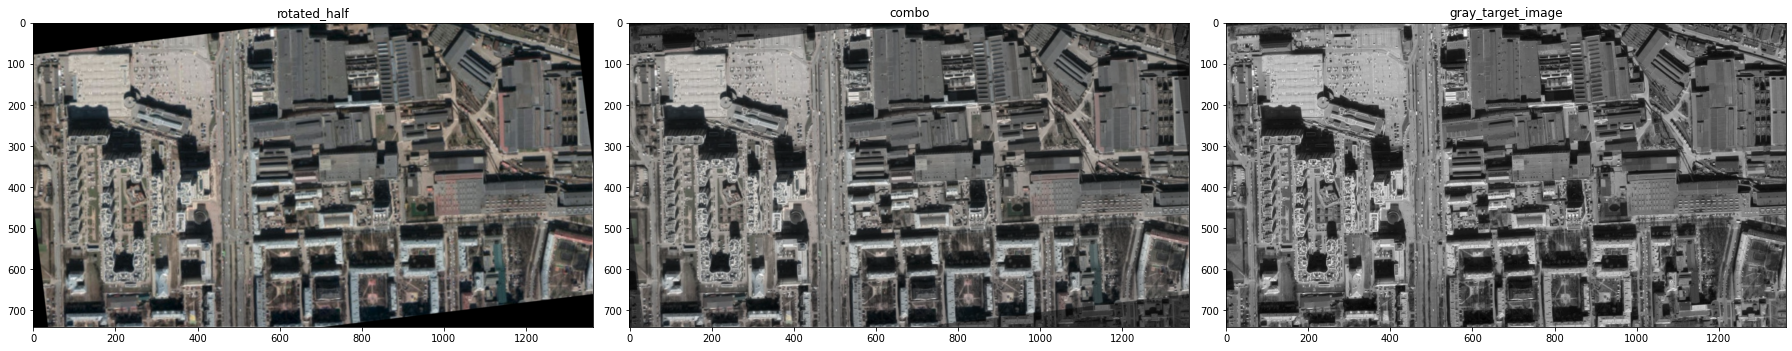

In [48]:
draw_graph(
    image_1=rotated_half, 
    title_1='rotated_half',
    image_2=new_image_half,
    title_2='combo',
    image_3=gray_target_image, 
    title_3='gray_target_image'
    )

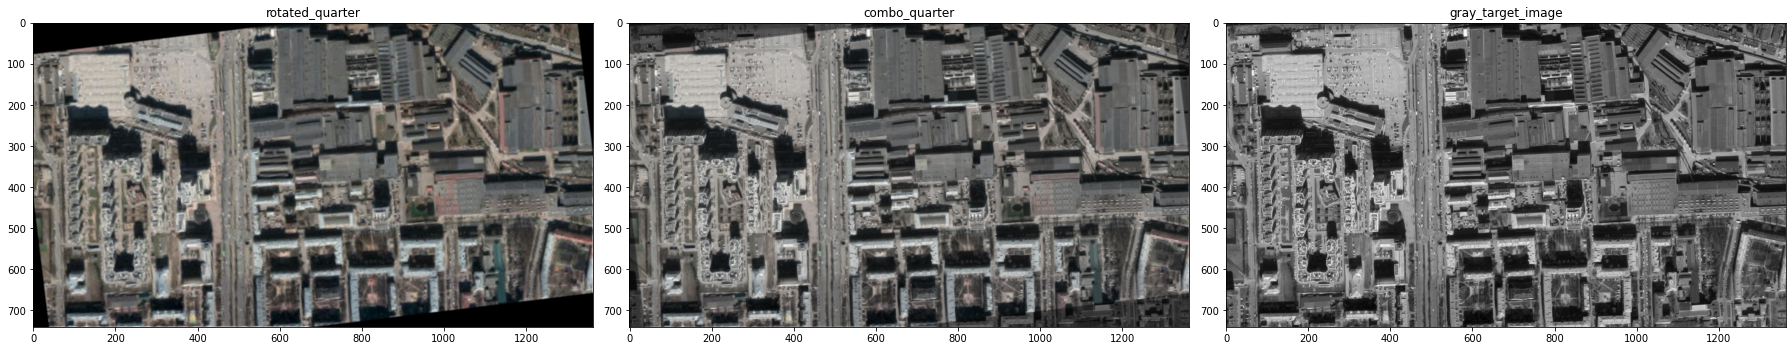

In [49]:
draw_graph(
    image_1=rotated_quarter, 
    title_1='rotated_quarter',
    image_2=new_image_quarter,
    title_2='combo_quarter',
    image_3=gray_target_image, 
    title_3='gray_target_image'
    )

## Results of alignment

In [50]:
rotated_half[rotated_half==0] = gray_target_image[rotated_half==0]
rotated_quarter[rotated_quarter==0] = gray_target_image[rotated_quarter==0]

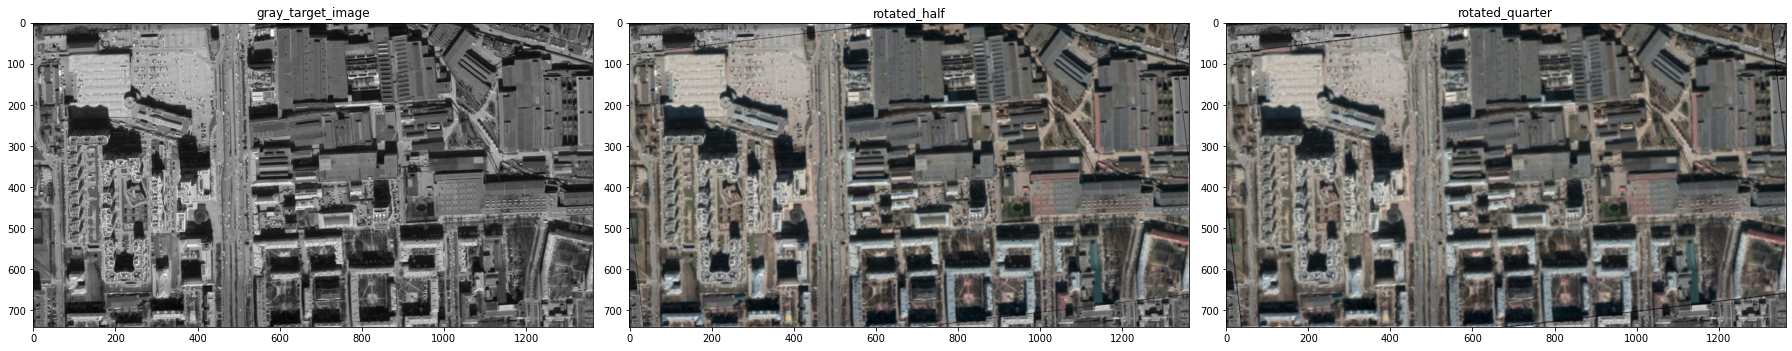

In [52]:
draw_graph(
    image_1=gray_target_image, 
    title_1='gray_target_image',
    image_2=rotated_half,
    title_2='rotated_half',
    image_3=rotated_quarter, 
    title_3='rotated_quarter'
    )

In [ ]:
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/gray.png", gray_target_image[:,:,::-1])
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_half.png", rotated_half[:,:,::-1])
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_quarter.png", rotated_quarter[:,:,::-1])

True

# Pan sharpening

## IHS based pan sharpening

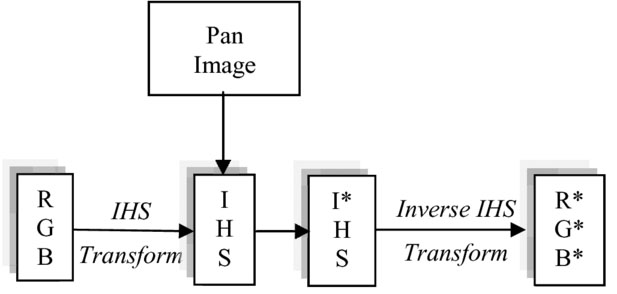

In [ ]:
# convert color to HSV
rotated_half_hsv = cv2.cvtColor(rotated_half, code=cv2.COLOR_BGR2HSV) 
rotated_quarter_hsv = cv2.cvtColor(rotated_quarter, code=cv2.COLOR_BGR2HSV) 

In [ ]:
pan_image = gray_target_image[:, :, 0]

rotated_half_hsv[:, :, 2] = pan_image
rotated_quarter_hsv[:, :, 2] = pan_image

In [ ]:
rotated_half_restore = cv2.cvtColor(rotated_half_hsv, code=cv2.COLOR_HSV2BGR) 
rotated_quarter_restore= cv2.cvtColor(rotated_quarter_hsv, code=cv2.COLOR_HSV2BGR) 

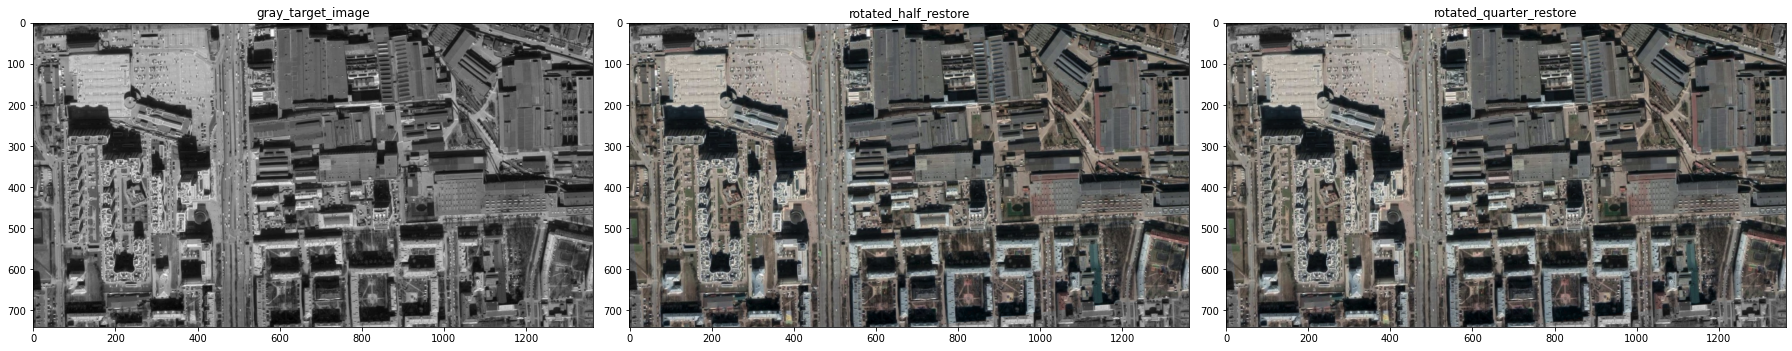

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.imshow(gray_target_image), plt.title('gray_target_image')
plt.subplot(132)
plt.imshow(rotated_half_restore), plt.title('rotated_half_restore')
plt.subplot(133)
plt.imshow(rotated_quarter_restore), plt.title('rotated_quarter_restore')
plt.tight_layout()
plt.show()

In [ ]:
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_half_restore.png", rotated_half_restore[:,:,::-1])
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_quarter_restore.png", rotated_quarter_restore[:,:,::-1])

True

## Brovey method

The Brovey Transform is a simple algorithm developed to optimise visual contrast at both ends of the spectral histogram. The approach multiplies each medium resolution band by the ratio of the higher resolution panchromatic band divided by the sum of all three multispectral bands.

In [41]:
def pan_sharpen_brovey(src_img, pan_img):
   
    eps = 1e-4
    sum_image = np.sum(src_img, axis=2) / 3
    ratio = pan_img / (sum_image + eps)

    src_img[:,:,0] = src_img[:,:,0] * ratio
    src_img[:,:,1] = src_img[:,:,1] * ratio
    src_img[:,:,2] = src_img[:,:,2] * ratio

    return src_img

In [ ]:
# image_half = cv2.imread('/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_half.png')[:,:,::-1]
# image_quarter = cv2.imread('/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/rgb_quarter.png')[:,:,::-1]
# gray = cv2.imread("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/gray.png", 0)

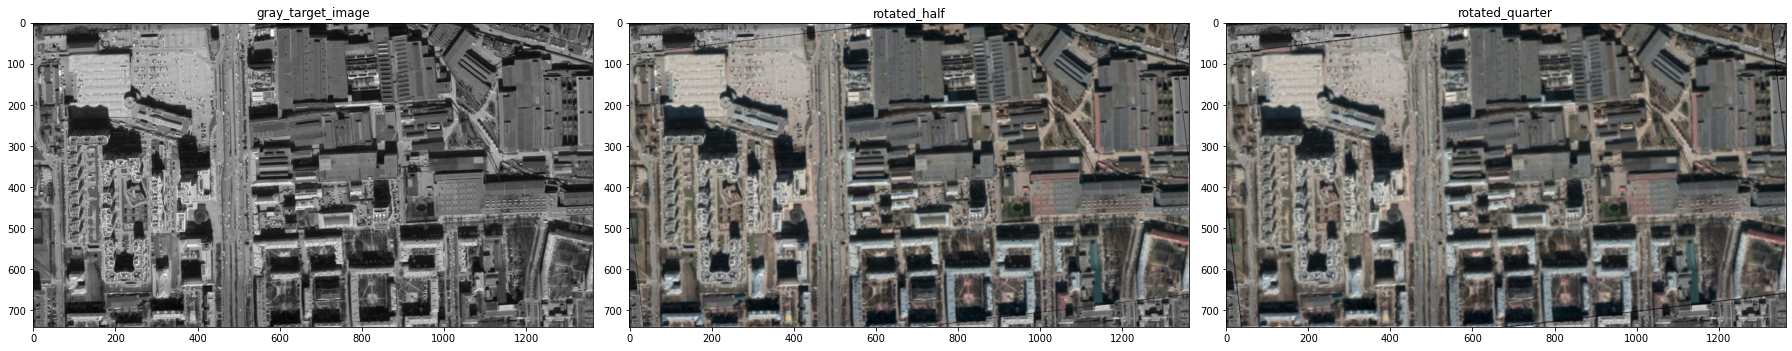

In [55]:
draw_graph(
    image_1=gray_target_image, 
    title_1='gray_target_image',
    image_2=rotated_half,
    title_2='rotated_half',
    image_3=rotated_quarter, 
    title_3='rotated_quarter'
    )

In [56]:
restored_image_h = pan_sharpen_brovey(
    src_img = rotated_half.copy(),
    pan_img = gray_target_image[:,:,0]
)

restored_image_q = pan_sharpen_brovey(
    src_img = rotated_quarter.copy(),
    pan_img = gray_target_image[:,:,0]
)

# image_half_restored = np.moveaxis(image_half_restored, 0, -1)
# image_quarter_restored = np.moveaxis(image_quarter_restored, 0, -1)

using Brovey method
using Brovey method


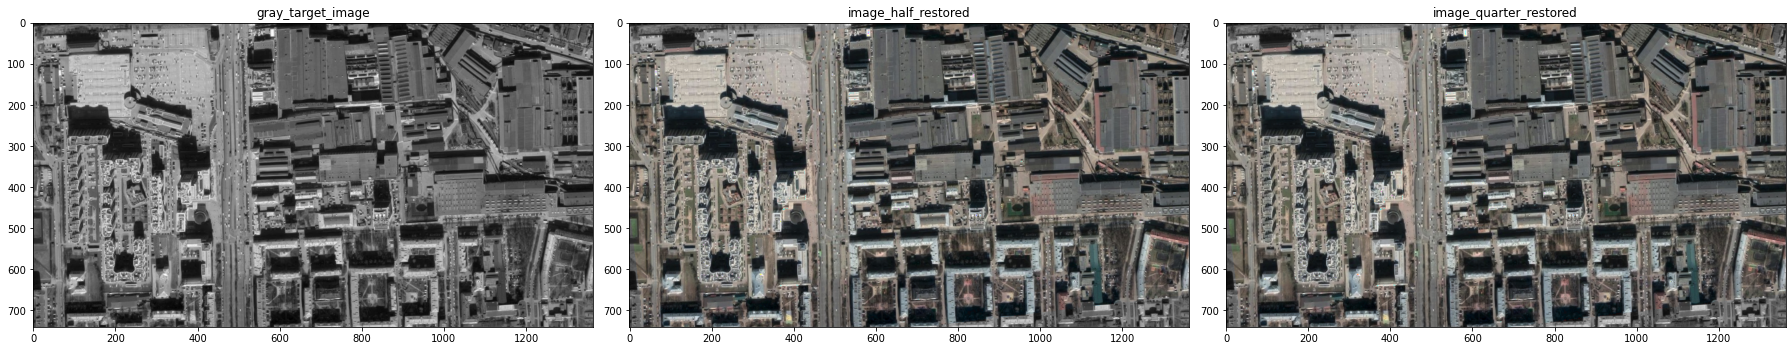

In [57]:
draw_graph(
    image_1=gray_target_image, 
    title_1='gray_target_image',
    image_2=restored_image_h,
    title_2='image_half_restored',
    image_3=restored_image_q, 
    title_3='image_quarter_restored'
    )

In [ ]:
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/brovey_half.png", image_half_resored[:,:,::-1])
cv2.imwrite("/content/gdrive/MyDrive/EPAM CV/Week 1. Image processing/data/brovey_quarter.png", image_quarter_resored[:,:,::-1])